<h3> Welcome to coursera capstone project on the "Battle of Neighbourhoods" 

In [1]:
import pandas as pd
import numpy as np

In [2]:
print(" Hello Capstone Project Course!")

 Hello Capstone Project Course!


#### Part 1 of Submission 1 for Coursera Capstone project
     
Step 1 is to extract information from this https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M wikipedia page using BeautifulSoup

In [30]:
from bs4 import BeautifulSoup
import requests

url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")
# print(soup.prettify()) # print the parsed data of html

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
toronto_df=pd.DataFrame(table_contents)
toronto_df['Borough']=toronto_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
toronto_df.head(11)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [6]:
toronto_df.shape

(103, 3)

## Part 2 

Let us now get the latitude and the longitude coordinates of each neighborhood for our data. We will be using the helper csv sheet provided in the description to map the lat, long values.

In [7]:
df_postcode = toronto_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
location_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')
toronto_data = df_postcode.join(location_df, on='PostalCode') #then you will get the latitude and longitude with respect to neighbourhood and not boroughs.
print(toronto_data.shape)
toronto_data.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3

Now that we have the dataset ready, let us explore it a bit before we start with any modeling.

In [8]:
#for starters, I am wondering how many boroughs do we have in total?

boroughs = toronto_data.Borough.unique()
print(len(toronto_data.Borough.unique()))
boroughs

15


array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'East York/East Toronto', 'Central Toronto', 'Downtown Toronto',
       'Downtown Toronto Stn A', 'York', 'West Toronto', "Queen's Park",
       'Mississauga', 'East Toronto Business', 'Etobicoke',
       'Etobicoke Northwest'], dtype=object)

### Let's go ahead and plot Map of Toronto and mark the neighborhoods 

In [9]:
# !conda install -c conda-forge geopy --yes #uncomment if using geopy for the first time
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [10]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
import folium
# create map of Toronto using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

## since the maps are not displayed in the github notebook, adding a screenshot of the same

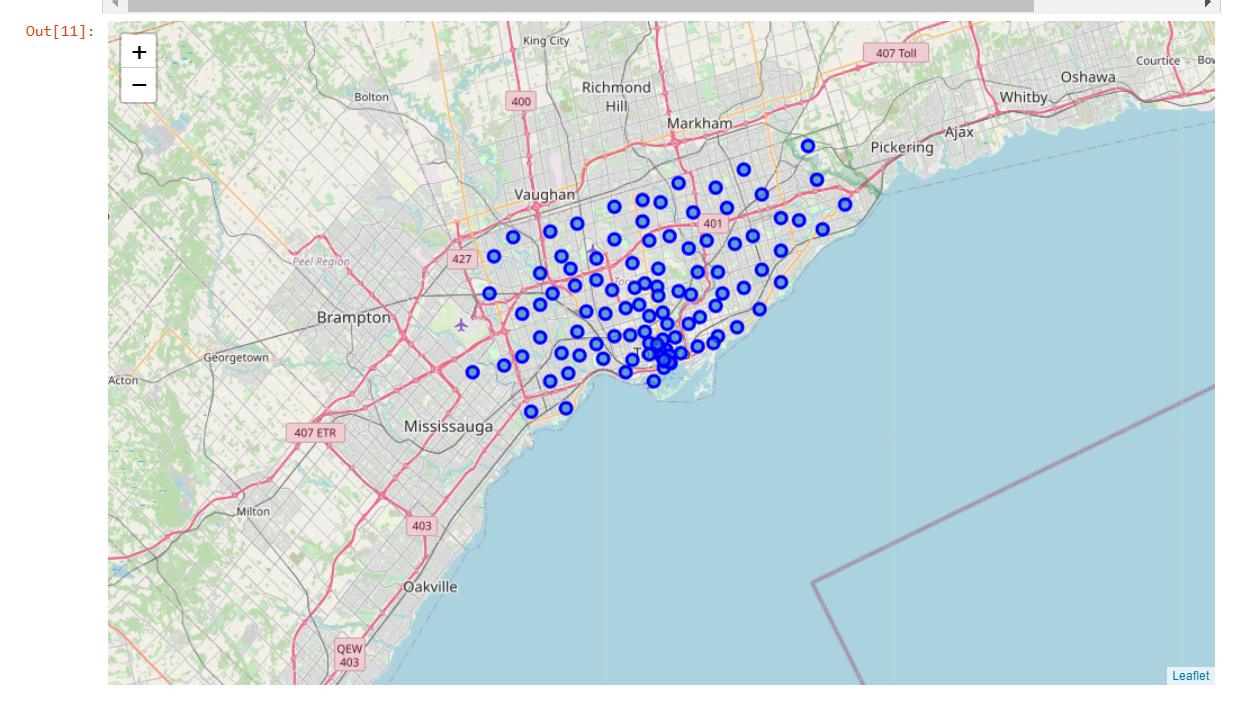

In [29]:
# Let us start getting the venue information for our neighbourhoods using foursquare api. For this we first define the credentials
CLIENT_ID = 'ANYR31ZU53RNDKHNCCND1NHCMY143K2WSAB0CJQXA********' # your Foursquare ID
CLIENT_SECRET = 'GE2SEI0ESM3IZEDPAGHY1Y55DR0XSIH1IBQZEN*********' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [13]:
#here we place a call to foursquare api to get venue info for all neighbourhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

radius = 500
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'], radius)
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
...,...,...,...,...,...,...,...
2122,"Clairville, Humberwood, Woodbine Downs, West H...",43.706748,-79.594054,Economy Rent A Car,43.708471,-79.589943,Rental Car Location
2123,"Clairville, Humberwood, Woodbine Downs, West H...",43.706748,-79.594054,Logistics Distribution,43.707554,-79.589252,Bar
2124,"Clairville, Humberwood, Woodbine Downs, West H...",43.706748,-79.594054,Saand Rexdale,43.705072,-79.598725,Drugstore
2125,"Clairville, Humberwood, Woodbine Downs, West H...",43.706748,-79.594054,PC Garden,43.706539,-79.599359,Garden Center


In [14]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
Willowdale West,7,7,7,7,7,7
"Willowdale, Newtonbrook",1,1,1,1,1,1
Woburn,4,4,4,4,4,4


In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 279 uniques categories.


In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(toronto_onehot.columns)

279

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#extract 10 most common venues for every neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with venues info
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Escape Room
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Pub,Dance Studio,Gym,Sandwich Place,Coffee Shop,Skating Rink,Pool,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sandwich Place,Supermarket,Sushi Restaurant,Mobile Phone Shop,Deli / Bodega,Middle Eastern Restaurant,Ice Cream Shop,Diner
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Liquor Store,Comfort Food Restaurant,Fast Food Restaurant,Juice Bar,Butcher


In [24]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [25]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3.0,Fast Food Restaurant,Women's Store,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Construction & Landscaping,Bar,Women's Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Intersection,Restaurant,Breakfast Spot,Electronics Store,Medical Center,Rental Car Location,Bank,Mexican Restaurant,Doner Restaurant,Distribution Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Indian Restaurant,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka Restaurant,Gas Station,Fried Chicken Joint,Bank,Bakery,Thai Restaurant,Athletics & Sports,Caribbean Restaurant,Creperie,Concert Hall


In [27]:
toronto_merged = toronto_merged.dropna()

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## since the maps are not displayed in the github notebook, adding a screenshot of the same
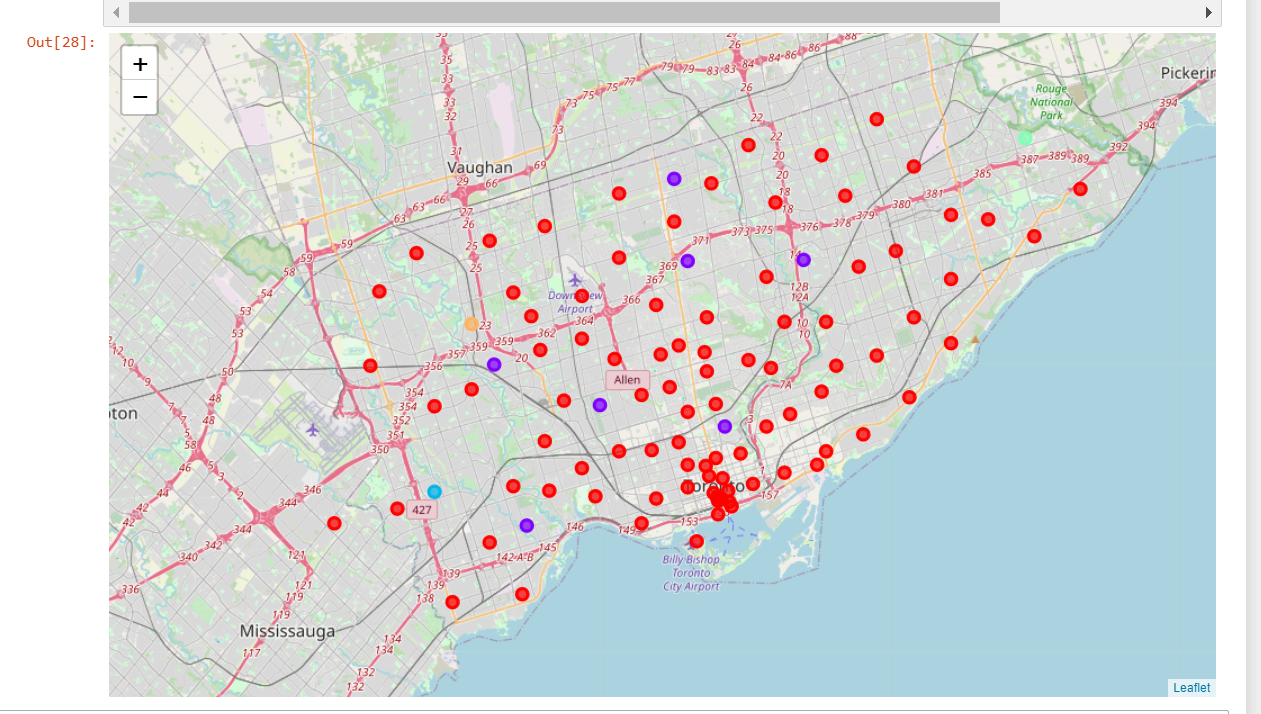